# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :**

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation.

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import Subset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_colwidth',True)

In [2]:
seed=11111
results=pd.DataFrame(columns=['Model','Number of epochs','Train accuracy','Test accuracy'])

In [3]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

batch_size = 10

original_subset = Subset(train_set, list(range(100)))

train_loader = DataLoader(original_subset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [5]:
len(train_loader.dataset)

100

In [6]:
test_loader= DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [7]:
remain_loader = DataLoader(Subset(train_set, list(range(100, len(train_set)))), batch_size=batch_size, shuffle=True)

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project.

* The remaining samples correspond to $\mathcal{X}$.

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

In [8]:
print(f'the size of the training set is {len(train_loader.dataset)}')

the size of the training set is 100


The size of the training set is too small to train a machine learning model especially neural network such as CNN, a try will possibly lead to an overfitting

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf.

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [9]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def predict(model,dataloader):
    result=[]
    model.eval()
    correct=0
    total=0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets= inputs.to(device), targets.to(device)
        outputs=model(inputs)
        _, predicted = outputs.max(1)
        result.append(predicted)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return torch.cat(result, dim=0), np.round(100.*correct/total,2)



def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])



In [10]:
model=ResNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    # cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [11]:
def train(model,epoch,criterion,optimizer,scheduler,train_loader):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss=0
    correct=0
    total=0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets= inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f'batch index:{batch_idx}| train_loss={np.round(train_loss/(batch_idx+1),2)} | correct_percentage={np.round(100.*correct/total,2)}')

#         progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
#                      % , 100.*correct/total, correct, total))



In [12]:
for epoch in range(0,10):
    train(model,epoch,criterion,optimizer,scheduler,train_loader)
    scheduler.step()


Epoch: 0
batch index:0| train_loss=2.49 | correct_percentage=0.0
batch index:1| train_loss=2.49 | correct_percentage=10.0
batch index:2| train_loss=2.57 | correct_percentage=6.67
batch index:3| train_loss=2.63 | correct_percentage=7.5
batch index:4| train_loss=2.77 | correct_percentage=6.0
batch index:5| train_loss=2.87 | correct_percentage=5.0
batch index:6| train_loss=2.79 | correct_percentage=7.14
batch index:7| train_loss=2.74 | correct_percentage=8.75
batch index:8| train_loss=2.77 | correct_percentage=10.0
batch index:9| train_loss=2.92 | correct_percentage=9.0

Epoch: 1
batch index:0| train_loss=3.1 | correct_percentage=10.0
batch index:1| train_loss=2.85 | correct_percentage=15.0
batch index:2| train_loss=2.97 | correct_percentage=10.0
batch index:3| train_loss=2.74 | correct_percentage=15.0
batch index:4| train_loss=2.69 | correct_percentage=16.0
batch index:5| train_loss=2.75 | correct_percentage=16.67
batch index:6| train_loss=2.74 | correct_percentage=17.14
batch index:7| 

In [16]:
# print(f"Accuracy on train set: {predict(model,train_loader)[1]}")
# print(f"Accuracy on train set: {predict(model,test_loader)[1]}")

In [17]:
baseline_train_accuracy=predict(model,train_loader)[1]
baseline_test_accuracy=predict(model,test_loader)[1]


In [18]:
results.loc[0] = ['ResNet-18 (from scratch)', 10, baseline_train_accuracy,baseline_test_accuracy]

In [19]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [20]:
from torchvision.models import resnet18

In [21]:
model18_pretrained=resnet18(pretrained=True)

/Users/jordan/anaconda3/envs/challengeQRT/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jordan/anaconda3/envs/challengeQRT/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
nb_feat_in_last_layer=model18_pretrained.fc.in_features

for param in model18_pretrained.parameters():
    param.requires_grad=False

model18_pretrained.fc=torch.nn.Linear(nb_feat_in_last_layer,len(train_set.class_to_idx))

model18_pretrained=model18_pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer18_pretrained = torch.optim.SGD(model18_pretrained.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler18_pretrained = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer18_pretrained, T_max=200)



In [23]:
for epoch in range(0,10):
    train(model18_pretrained,epoch,criterion,optimizer18_pretrained,scheduler18_pretrained,train_loader)
    scheduler18_pretrained.step()


Epoch: 0
batch index:0| train_loss=2.43 | correct_percentage=10.0
batch index:1| train_loss=2.68 | correct_percentage=15.0
batch index:2| train_loss=2.56 | correct_percentage=13.33
batch index:3| train_loss=2.56 | correct_percentage=15.0
batch index:4| train_loss=2.53 | correct_percentage=14.0
batch index:5| train_loss=2.5 | correct_percentage=16.67
batch index:6| train_loss=2.5 | correct_percentage=17.14
batch index:7| train_loss=2.61 | correct_percentage=16.25
batch index:8| train_loss=2.74 | correct_percentage=16.67
batch index:9| train_loss=2.73 | correct_percentage=19.0

Epoch: 1
batch index:0| train_loss=2.49 | correct_percentage=20.0
batch index:1| train_loss=2.36 | correct_percentage=20.0
batch index:2| train_loss=1.94 | correct_percentage=36.67
batch index:3| train_loss=2.32 | correct_percentage=32.5
batch index:4| train_loss=2.16 | correct_percentage=36.0
batch index:5| train_loss=2.28 | correct_percentage=33.33
batch index:6| train_loss=2.24 | correct_percentage=32.86
batch

In [24]:
# print(f"Accuracy on train set: {predict(model18_pretrained,train_loader)[1]}")
# print(f"Accuracy on train set: {predict(model18_pretrained,test_loader)[1]}")

In [25]:
model_pretrained_train_accuracy=predict(model18_pretrained,train_loader)[1]
model_pretrained_test_accuracy=predict(model18_pretrained,test_loader)[1]

In [26]:
results.loc[1] = ['ResNet-18 (pretrained)', 10, model_pretrained_train_accuracy,model_pretrained_test_accuracy]


In [27]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71
1,ResNet-18 (pretrained),10,85.0,21.59


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

## Random Rotation

In [28]:
transform1 = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomCrop((224, 224)),
#     transforms.ColorJitter(brightness=0.5),
    transforms.RandomRotation(degrees=45),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform2 = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.5),
#     transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform3 = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomCrop((224, 224)),
#     transforms.ColorJitter(brightness=0.5),
#     transforms.RandomRotation(degrees=45),
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [29]:
def augmented_trainloader(transforms,original_subset):
    augmented_dataset = []
    print('results after applying transformation \n')
    for idx in range(len(original_subset)):

        img, label = original_subset[idx]
        augmented_img = transform1(img)
        augmented_dataset.append((augmented_img, label))

        if idx%20==0:

            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
            ax_img = axes[0]
            ax_img.imshow(np.transpose(img, (1, 2, 0)))
            ax_img.set_title(f"original image")
            ax_img.axis('off')

            ax_augmented_img = axes[1]
            ax_augmented_img.imshow(np.transpose(augmented_img, (1, 2, 0)))
            ax_augmented_img.set_title(f"augmented image")
            ax_augmented_img.axis('off')

    concatenated_dataset = torch.utils.data.ConcatDataset([original_subset, augmented_dataset])
    train_loader = DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)
    plt.show()
    return train_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


results after applying transformation 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


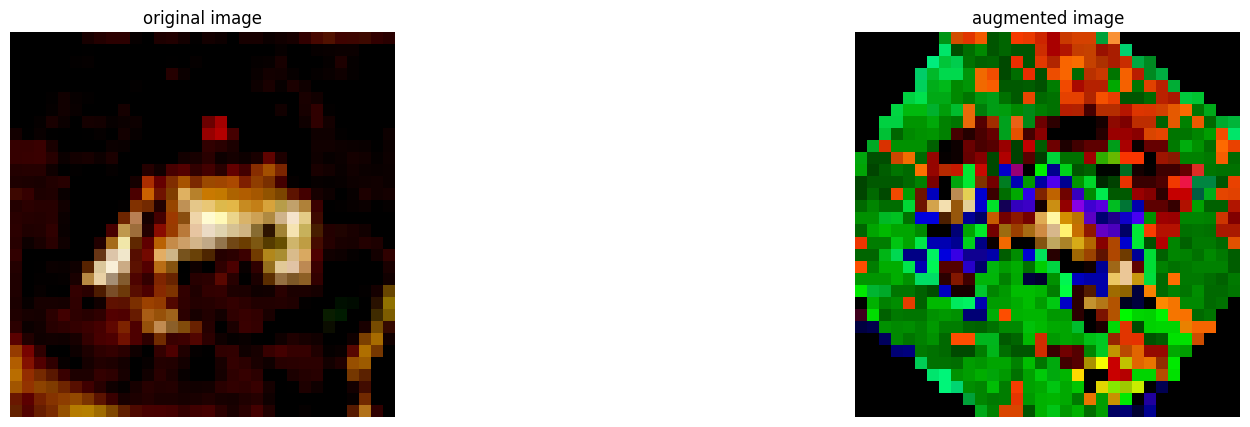

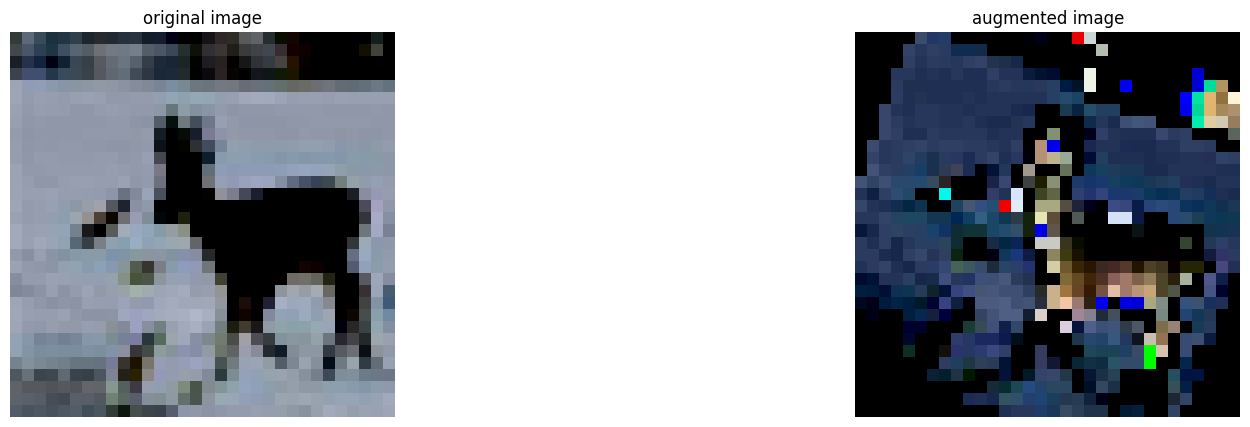

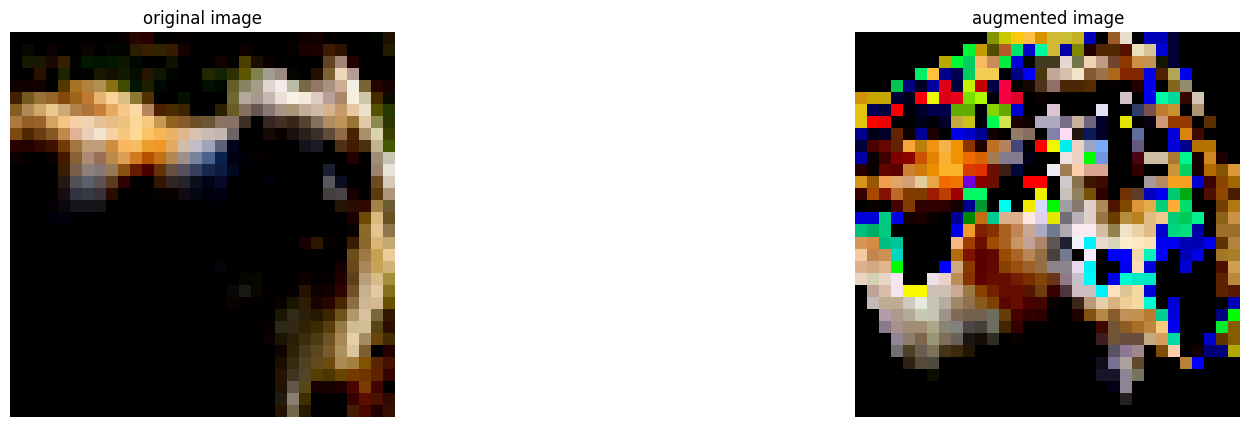

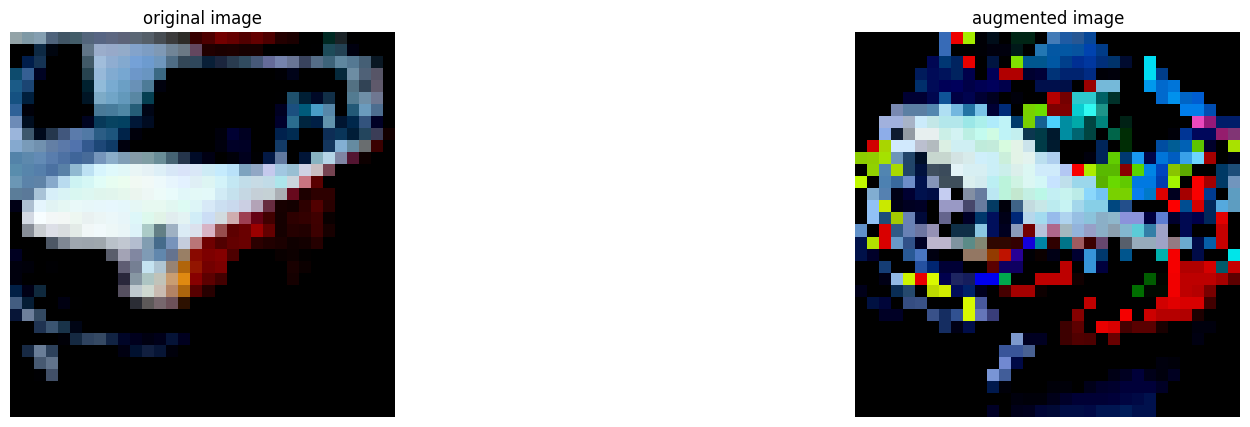

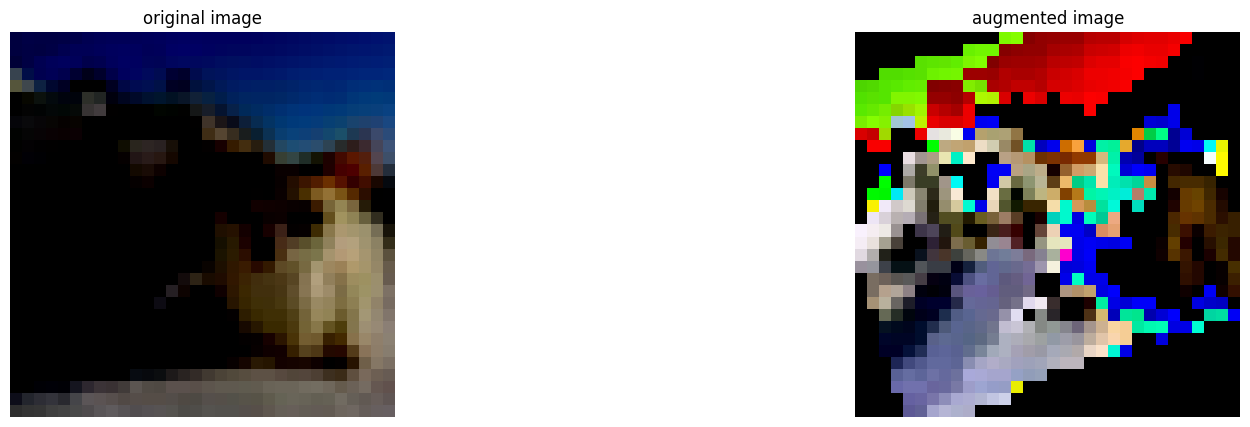

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

results after applying transformation 



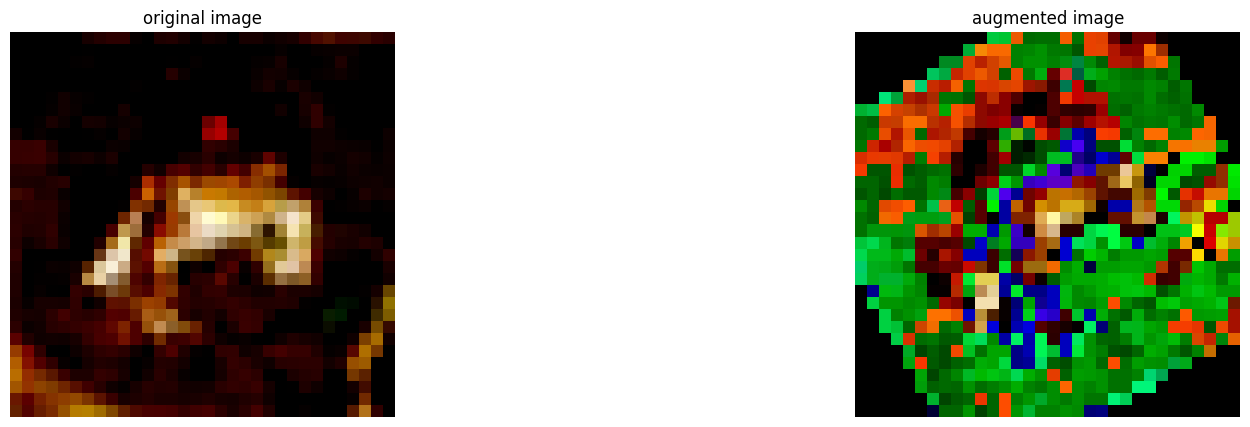

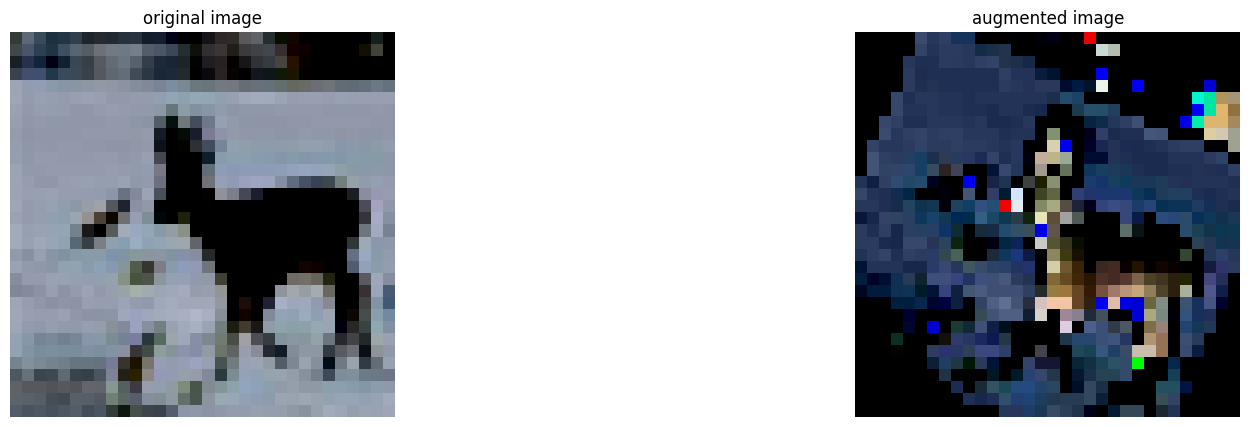

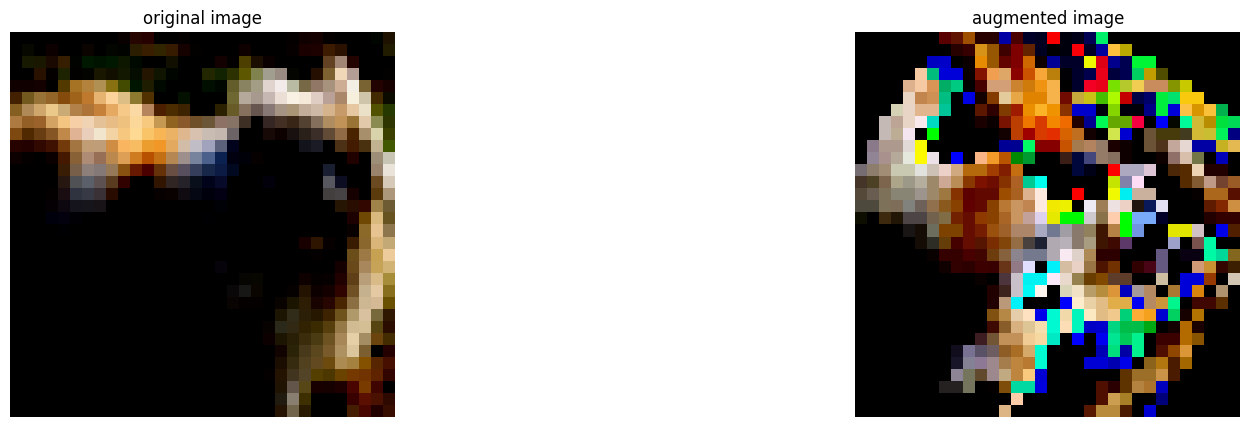

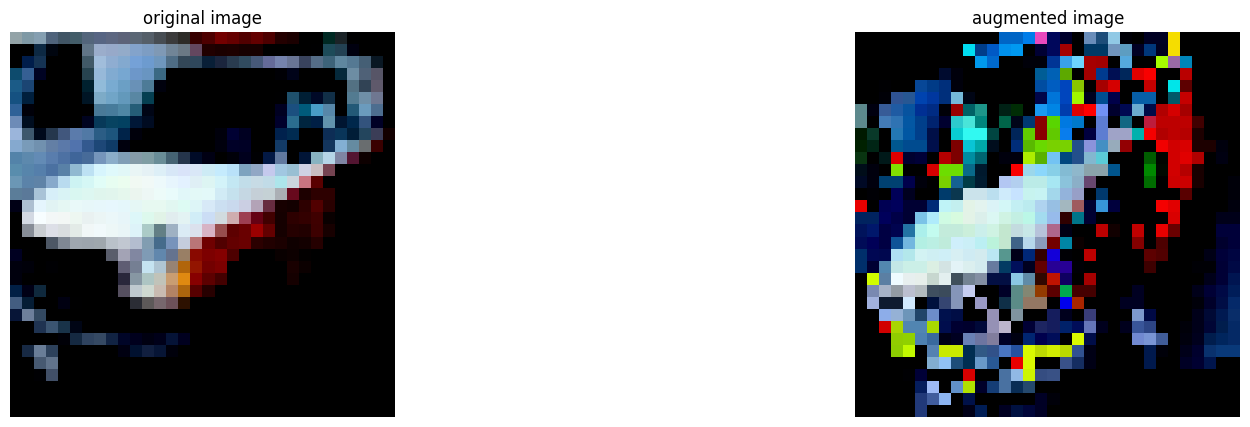

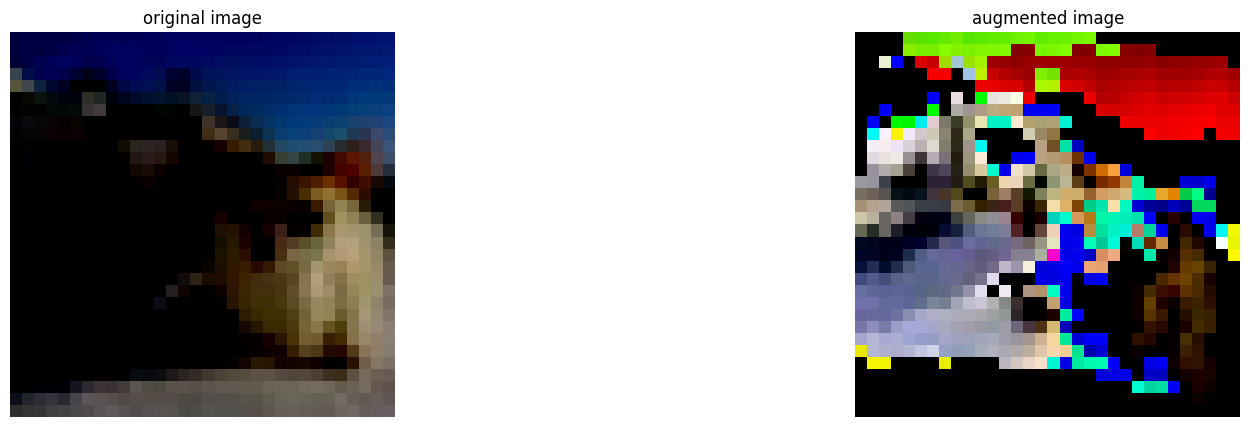

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

results after applying transformation 



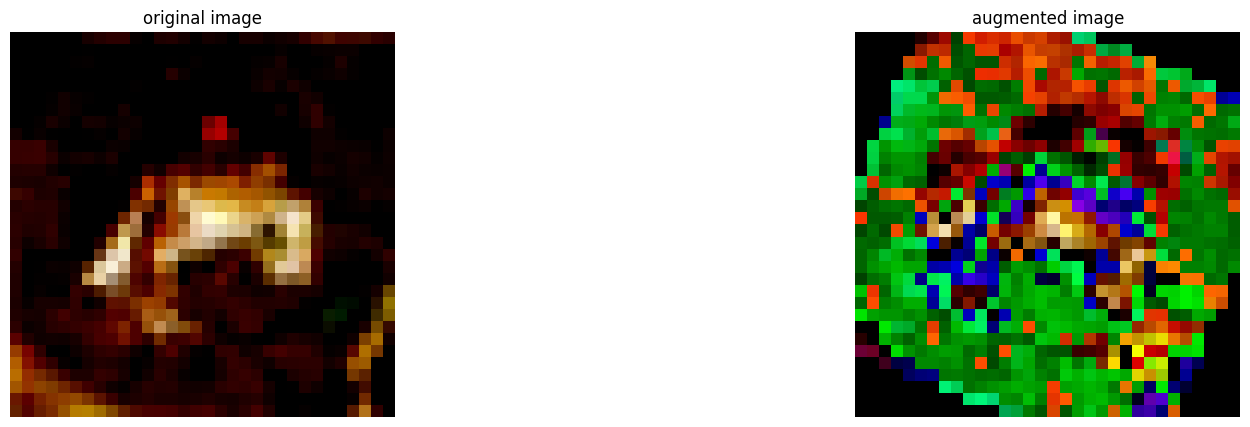

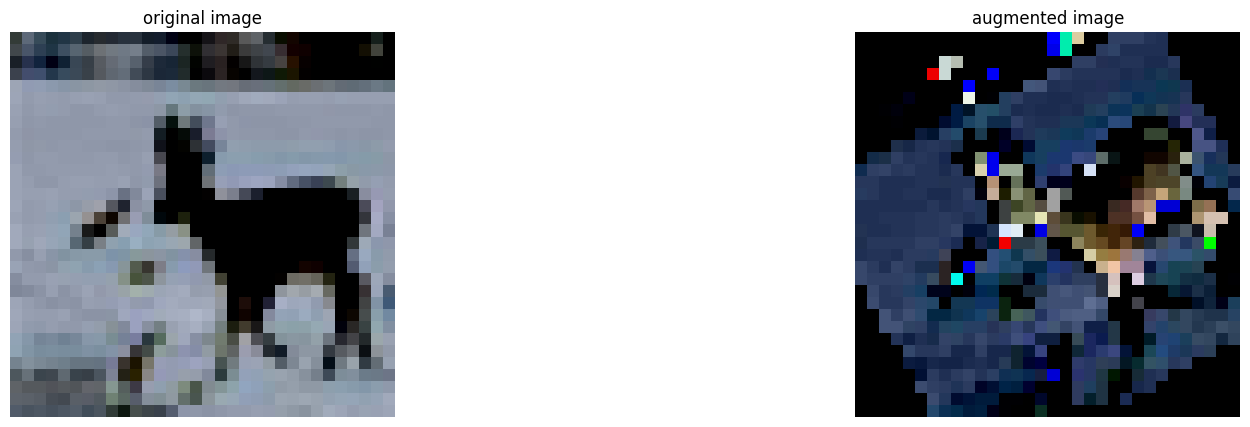

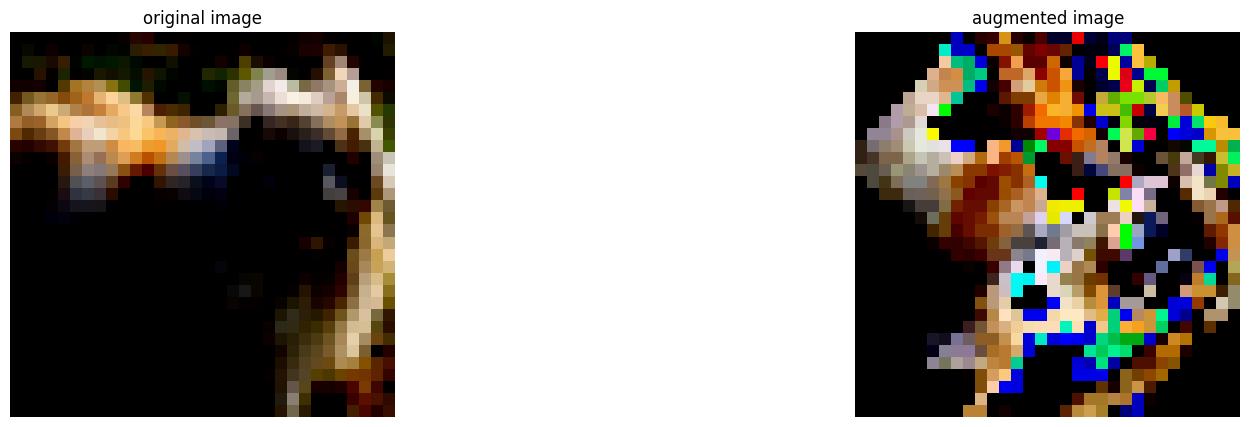

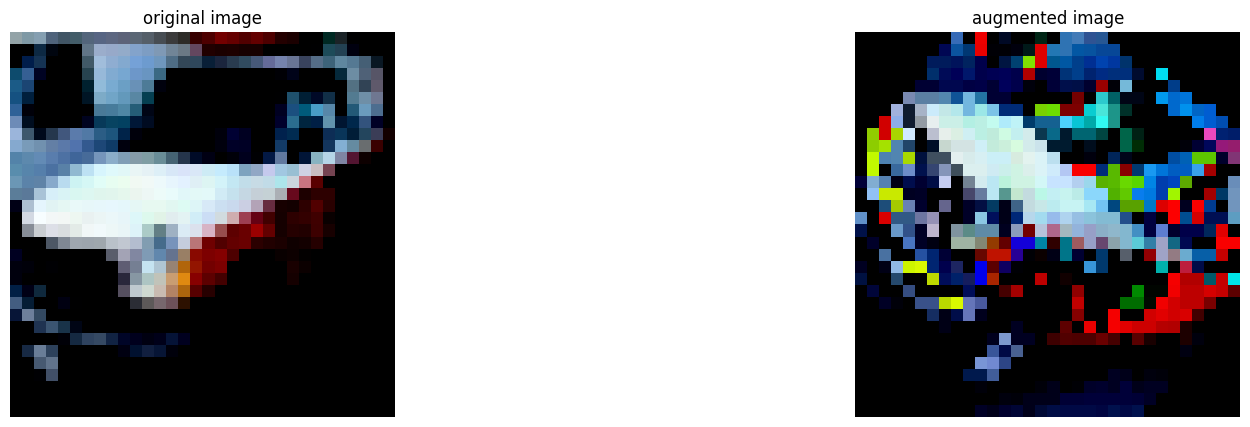

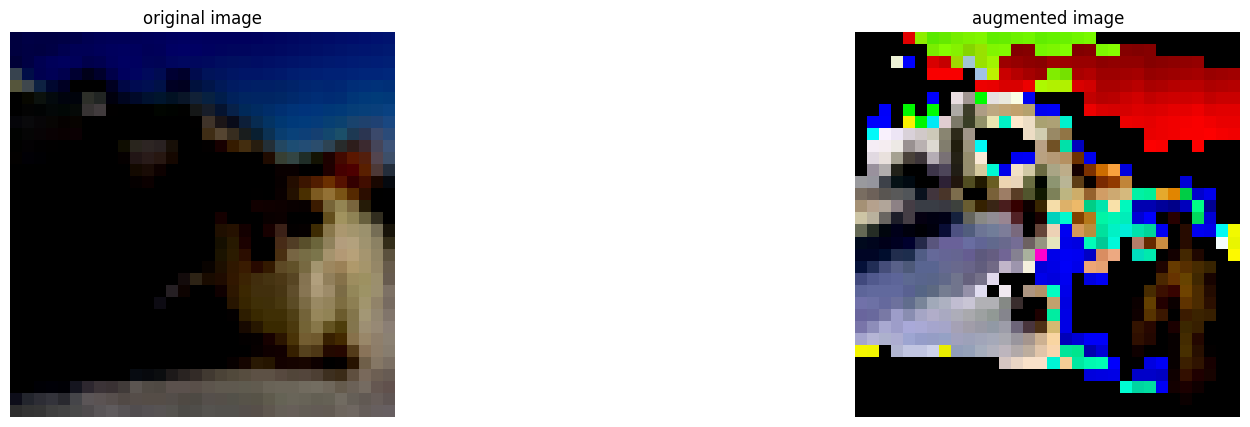

In [30]:
train_loader_1= augmented_trainloader(transform1,original_subset)
train_loader_2= augmented_trainloader(transform1,original_subset)
train_loader_3= augmented_trainloader(transform1,original_subset)

In [31]:
model_1=ResNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)

if device == 'cuda':
    model_1 = torch.nn.DataParallel(model_1)
    # cudnn.benchmark = True

optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler_1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_1, T_max=200)

for epoch in range(0,10):
    train(model_1,epoch,criterion,optimizer_1,scheduler_1,train_loader_1)
    scheduler.step()


Epoch: 0
batch index:0| train_loss=2.62 | correct_percentage=0.0
batch index:1| train_loss=2.53 | correct_percentage=10.0
batch index:2| train_loss=2.49 | correct_percentage=16.67
batch index:3| train_loss=2.46 | correct_percentage=15.0
batch index:4| train_loss=2.48 | correct_percentage=16.0
batch index:5| train_loss=2.69 | correct_percentage=13.33
batch index:6| train_loss=2.62 | correct_percentage=12.86
batch index:7| train_loss=2.63 | correct_percentage=13.75
batch index:8| train_loss=2.6 | correct_percentage=13.33
batch index:9| train_loss=2.6 | correct_percentage=13.0
batch index:10| train_loss=2.66 | correct_percentage=12.73
batch index:11| train_loss=2.72 | correct_percentage=12.5
batch index:12| train_loss=2.74 | correct_percentage=12.31
batch index:13| train_loss=2.74 | correct_percentage=12.14
batch index:14| train_loss=2.73 | correct_percentage=14.0
batch index:15| train_loss=2.74 | correct_percentage=13.75
batch index:16| train_loss=2.71 | correct_percentage=14.12
batch i

batch index:2| train_loss=1.74 | correct_percentage=46.67
batch index:3| train_loss=1.59 | correct_percentage=52.5
batch index:4| train_loss=1.5 | correct_percentage=56.0
batch index:5| train_loss=1.82 | correct_percentage=50.0
batch index:6| train_loss=1.87 | correct_percentage=45.71
batch index:7| train_loss=1.81 | correct_percentage=43.75
batch index:8| train_loss=1.91 | correct_percentage=40.0
batch index:9| train_loss=1.87 | correct_percentage=42.0
batch index:10| train_loss=1.86 | correct_percentage=41.82
batch index:11| train_loss=1.83 | correct_percentage=43.33
batch index:12| train_loss=1.8 | correct_percentage=43.85
batch index:13| train_loss=1.76 | correct_percentage=43.57
batch index:14| train_loss=1.82 | correct_percentage=42.0
batch index:15| train_loss=1.89 | correct_percentage=42.5
batch index:16| train_loss=1.96 | correct_percentage=41.18
batch index:17| train_loss=1.99 | correct_percentage=40.0
batch index:18| train_loss=1.96 | correct_percentage=41.05
batch index:19|

In [32]:
# print(f"Accuracy on train set: {predict(model_1,train_loader)[1]}")
# print(f"Accuracy on train set: {predict(model_1,test_loader)[1]}")

In [33]:
model_transfo1_train_accuracy=predict(model_1,train_loader)[1]
model_transfo1_test_accuracy=predict(model_1,test_loader)[1]

In [34]:
results.loc[2] = ['ResNet-18 (from scratch, data augmented rotation)', 10, model_transfo1_train_accuracy,model_transfo1_test_accuracy]

In [35]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71
1,ResNet-18 (pretrained),10,85.0,21.59
2,"ResNet-18 (from scratch, data augmented rotation)",10,54.0,20.34


In [36]:
model_2 = ResNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_2.to(device)

if device == 'cuda':
    model_2 = torch.nn.DataParallel(model_2)
    # cudnn.benchmark = True

optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01,
                              momentum=0.9, weight_decay=5e-4)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_2, T_max=200)

for epoch in range(0, 10):
    train(model_2, epoch, criterion, optimizer_2, scheduler_2, train_loader_2)
    scheduler.step()



Epoch: 0
batch index:0| train_loss=2.48 | correct_percentage=0.0
batch index:1| train_loss=2.5 | correct_percentage=0.0
batch index:2| train_loss=2.51 | correct_percentage=3.33
batch index:3| train_loss=2.51 | correct_percentage=5.0
batch index:4| train_loss=2.53 | correct_percentage=8.0
batch index:5| train_loss=2.58 | correct_percentage=10.0
batch index:6| train_loss=2.67 | correct_percentage=8.57
batch index:7| train_loss=2.67 | correct_percentage=11.25
batch index:8| train_loss=2.64 | correct_percentage=11.11
batch index:9| train_loss=2.72 | correct_percentage=11.0
batch index:10| train_loss=2.62 | correct_percentage=12.73
batch index:11| train_loss=2.65 | correct_percentage=11.67
batch index:12| train_loss=2.73 | correct_percentage=10.77
batch index:13| train_loss=2.72 | correct_percentage=12.86
batch index:14| train_loss=2.7 | correct_percentage=12.67
batch index:15| train_loss=2.66 | correct_percentage=13.75
batch index:16| train_loss=2.82 | correct_percentage=14.12
batch index

batch index:1| train_loss=2.7 | correct_percentage=15.0
batch index:2| train_loss=2.47 | correct_percentage=26.67
batch index:3| train_loss=2.43 | correct_percentage=20.0
batch index:4| train_loss=2.41 | correct_percentage=20.0
batch index:5| train_loss=2.44 | correct_percentage=18.33
batch index:6| train_loss=2.41 | correct_percentage=20.0
batch index:7| train_loss=2.31 | correct_percentage=23.75
batch index:8| train_loss=2.28 | correct_percentage=25.56
batch index:9| train_loss=2.3 | correct_percentage=24.0
batch index:10| train_loss=2.34 | correct_percentage=21.82
batch index:11| train_loss=2.32 | correct_percentage=21.67
batch index:12| train_loss=2.33 | correct_percentage=20.77
batch index:13| train_loss=2.29 | correct_percentage=20.71
batch index:14| train_loss=2.28 | correct_percentage=21.33
batch index:15| train_loss=2.29 | correct_percentage=20.62
batch index:16| train_loss=2.33 | correct_percentage=20.59
batch index:17| train_loss=2.34 | correct_percentage=20.0
batch index:18

In [37]:
# print(f"Accuracy on train set: {predict(model_2,train_loader)[1]}")
# print(f"Accuracy on test set: {predict(model_2,test_loader)[1]}")

In [38]:
model_transfo2_train_accuracy=predict(model_2,train_loader)[1]
model_transfo2_test_accuracy=predict(model_2,test_loader)[1]

In [39]:
results.loc[3] = ['ResNet-18 (from scratch, data augmented color + horizontal flip)', 10, model_transfo2_train_accuracy,model_transfo2_test_accuracy]

In [40]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71
1,ResNet-18 (pretrained),10,85.0,21.59
2,"ResNet-18 (from scratch, data augmented rotation)",10,54.0,20.34
3,"ResNet-18 (from scratch, data augmented color + horizontal flip)",10,29.0,17.79


In [41]:
model_3 = ResNet18()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_3.to(device)

if device == 'cuda':
    model_3 = torch.nn.DataParallel(model_3)
    # cudnn.benchmark = True

optimizer_3 = torch.optim.SGD(model_3.parameters(), lr=0.01,
                              momentum=0.9, weight_decay=5e-4)
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_3, T_max=200)

for epoch in range(0, 10):
    train(model_3, epoch, criterion, optimizer_3, scheduler_3, train_loader_3)
    scheduler.step()



Epoch: 0
batch index:0| train_loss=2.54 | correct_percentage=0.0
batch index:1| train_loss=2.56 | correct_percentage=5.0
batch index:2| train_loss=2.56 | correct_percentage=6.67
batch index:3| train_loss=2.56 | correct_percentage=10.0
batch index:4| train_loss=2.43 | correct_percentage=16.0
batch index:5| train_loss=2.43 | correct_percentage=15.0
batch index:6| train_loss=2.55 | correct_percentage=14.29
batch index:7| train_loss=2.53 | correct_percentage=15.0
batch index:8| train_loss=2.51 | correct_percentage=14.44
batch index:9| train_loss=2.55 | correct_percentage=15.0
batch index:10| train_loss=2.59 | correct_percentage=13.64
batch index:11| train_loss=2.62 | correct_percentage=12.5
batch index:12| train_loss=2.72 | correct_percentage=11.54
batch index:13| train_loss=2.74 | correct_percentage=11.43
batch index:14| train_loss=2.71 | correct_percentage=12.67
batch index:15| train_loss=2.66 | correct_percentage=14.38
batch index:16| train_loss=2.68 | correct_percentage=14.71
batch in

batch index:1| train_loss=2.04 | correct_percentage=20.0
batch index:2| train_loss=1.93 | correct_percentage=26.67
batch index:3| train_loss=1.85 | correct_percentage=27.5
batch index:4| train_loss=1.78 | correct_percentage=34.0
batch index:5| train_loss=1.68 | correct_percentage=38.33
batch index:6| train_loss=1.74 | correct_percentage=37.14
batch index:7| train_loss=1.78 | correct_percentage=36.25
batch index:8| train_loss=1.76 | correct_percentage=37.78
batch index:9| train_loss=1.79 | correct_percentage=36.0
batch index:10| train_loss=1.71 | correct_percentage=40.0
batch index:11| train_loss=1.73 | correct_percentage=40.83
batch index:12| train_loss=1.79 | correct_percentage=40.0
batch index:13| train_loss=1.85 | correct_percentage=39.29
batch index:14| train_loss=1.82 | correct_percentage=39.33
batch index:15| train_loss=1.91 | correct_percentage=38.12
batch index:16| train_loss=1.92 | correct_percentage=38.24
batch index:17| train_loss=1.92 | correct_percentage=37.78
batch index:

In [43]:
# print(f"Accuracy on train set: {predict(model_3,train_loader)[1]}")
# print(f"Accuracy on train set: {predict(model_3,test_loader)[1]}")

Accuracy on train set: 57.0
Accuracy on train set: 20.52


In [44]:
model_transfo3_train_accuracy=predict(model_3,train_loader)[1]
model_transfo3_test_accuracy=predict(model_3,test_loader)[1]

In [45]:
results.loc[4] = ['ResNet-18 (from scratch, data augmented GrayScale)', 10, model_transfo3_train_accuracy,model_transfo3_test_accuracy]

In [46]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71
1,ResNet-18 (pretrained),10,85.0,21.59
2,"ResNet-18 (from scratch, data augmented rotation)",10,54.0,20.34
3,"ResNet-18 (from scratch, data augmented color + horizontal flip)",10,29.0,17.79
4,"ResNet-18 (from scratch, data augmented GrayScale)",10,57.0,20.52


As we could observe the model performance strongly depend on the transformation we use, it could group with less coherent transformation such as color jittering and horizontal flip and it could increase with more realistic transformation such as rotation, so in order to apply a transformation we must study our dataset and make sure the transformation we want to apply match with the potential caracteristic of the dataset.

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

In this lab, we tackled the CIFAR-10 classification task using a ResNet18 deep learning model. To improve the performance of our basic model, we implemented two methods: transfer learning and data augmentation. Transfer learning consists of using a model pre-trained with a similar task and adapting it to our task. This method logically improves the performance of the base model, since we exploit the information learned by the pre-trained model, which only requires rapid adaptations. However, it may be rare to find a similar task solved, and it is necessary to carefully consider how to freeze and unfreeze the pre-trained weights.

On the other hand, data augmentation involves increasing the training samples by generating new samples through transformations of the original samples. The effectiveness of data augmentation depends on the transformations chosen, with the potential to improve performance if the subject is well understood. However, poorly chosen transformations can decrease performance. Moreover it is necessary to increase the number of epochs to take into account the new dataset size, that could increase the training time. Therefore, while data augmentation offers potential benefits, it requires careful selection and testing of transformations to ensure that they improve rather than hinder classification accuracy.

In [47]:
display(results)

,Model,Number of epochs,Train accuracy,Test accuracy
0,ResNet-18 (from scratch),10,79.0,17.71
1,ResNet-18 (pretrained),10,85.0,21.59
2,"ResNet-18 (from scratch, data augmented rotation)",10,54.0,20.34
3,"ResNet-18 (from scratch, data augmented color + horizontal flip)",10,29.0,17.79
4,"ResNet-18 (from scratch, data augmented GrayScale)",10,57.0,20.52


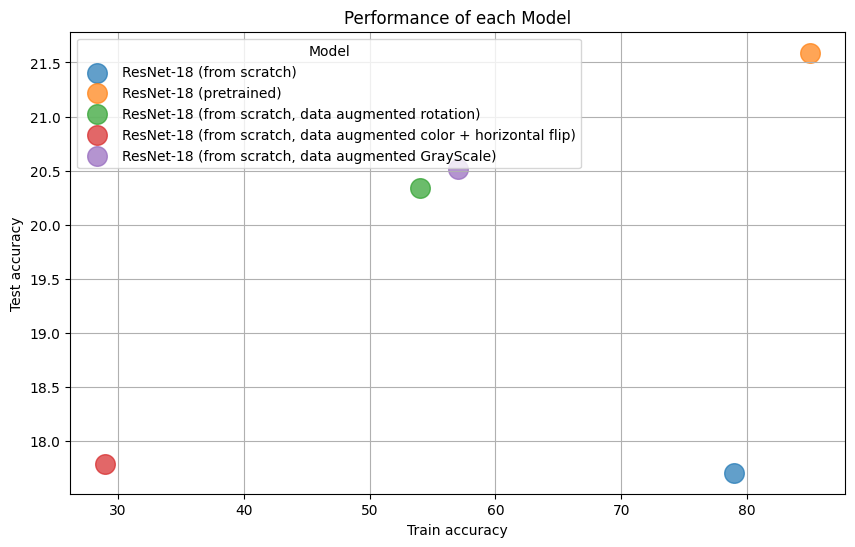

In [48]:
plt.figure(figsize=(10, 6))

# Iterate over each row to plot points with different colors for each model
for i, row in results.iterrows():
    plt.scatter(row['Train accuracy'], row['Test accuracy'], s=200, label=row['Model'], alpha=0.7)

plt.xlabel('Train accuracy')
plt.ylabel('Test accuracy')
plt.title('Performance of each Model')
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.